# 1D harmonic oscillator physics-informed neural network (PINN)

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


In [17]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, X={X[train_index]}, y={y[train_index]}")
    print(f"  Test:  index={test_index}, X={X[test_index]}, y={y[test_index]}")


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
Fold 0:
  Train: index=[0], X=[[1 2]], y=[1]
  Test:  index=[1], X=[[3 4]], y=[2]
Fold 1:
  Train: index=[0 1], X=[[1 2]
 [3 4]], y=[1 2]
  Test:  index=[2], X=[[1 2]], y=[3]
Fold 2:
  Train: index=[0 1 2], X=[[1 2]
 [3 4]
 [1 2]], y=[1 2 3]
  Test:  index=[3], X=[[3 4]], y=[4]
Fold 3:
  Train: index=[0 1 2 3], X=[[1 2]
 [3 4]
 [1 2]
 [3 4]], y=[1 2 3 4]
  Test:  index=[4], X=[[1 2]], y=[5]
Fold 4:
  Train: index=[0 1 2 3 4], X=[[1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]], y=[1 2 3 4 5]
  Test:  index=[5], X=[[3 4]], y=[6]


# Acausal function approximation $f(t) = x(t)$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from models import KAN, NN, KASSM
from layers import Sine, Cosine
from losses import oscillator, oscillator_loss
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.set_default_device(device)

import numpy as np
import matplotlib.pyplot as plt

# Initialize model, optimizer, and training parameters
model = KAN([1, 50, 50, 1]) # f(t) = x(t)
model = NN(1, [50, 50], 1) # f(t) = x(t)
# model = KASSM(1, 1, 1, [50, 50]) # f(t_0, x_0) = x(t_1)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

d, w0 = 2, 40
mu, k = 2*d, w0**2

d, w0 = torch.Tensor([d]), torch.Tensor([w0])
mu, k = torch.Tensor([mu]), torch.Tensor([k])

plosses = []
dlosses = []

# list to track moving average of loss
losses = []  # moving average of loss

# Training loop
for epoch in range(100):
    optimizer.zero_grad()

    ploss, dloss, icloss = oscillator_loss(model, mu, k, d, w0)
    ploss *= 1e-4
    loss = ploss + dloss + icloss
    # loss = dloss
    loss.backward()
    optimizer.step()

    # calculate moving average of loss
    if len(losses) < 100:
        losses.append(loss.item())
    else:
        losses.pop(0)
        losses.append(loss.item())
    
    # check if loss has converged
    std = np.std(losses)
    mean = np.mean(losses)
    if len(losses) == 100 and std < 5e-6 and epoch > 1000 and loss.item() < 1e-5:
        print(f'Converged at epoch {epoch}')
        break
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch},\
        Loss: {mean:.3e},\
        Physics Loss: {ploss.item():.3e},\
        Data Loss: {dloss.item():.3e},\
        IC Loss: {icloss.item():.3e},\
        Loss Std: {std:.3e}')
        scheduler.step()
    
    plosses.append(ploss.item())
    dlosses.append(dloss.item())


/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0,        Loss: 7.353e+00,        Physics Loss: 6.399e+00,        Data Loss: 2.909e-01,        IC Loss: 6.632e-01,        Loss Std: 0.000e+00


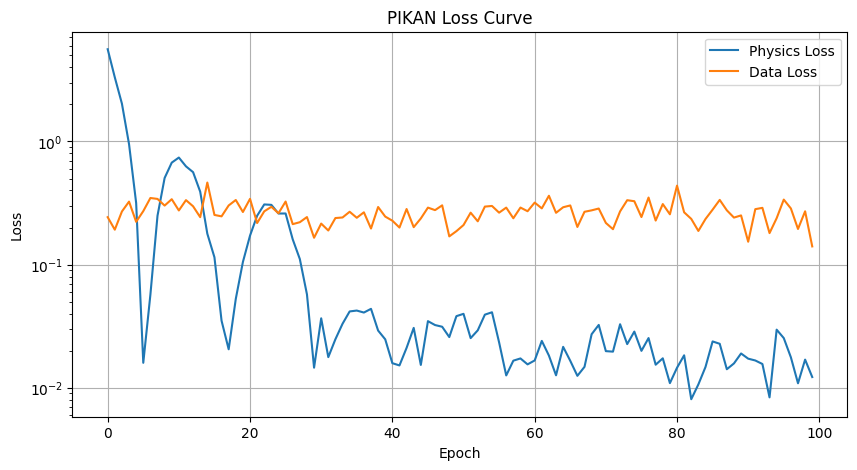

In [4]:
# plot log loss curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(plosses, label='Physics Loss')
ax.plot(dlosses, label='Data Loss')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PIKAN Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


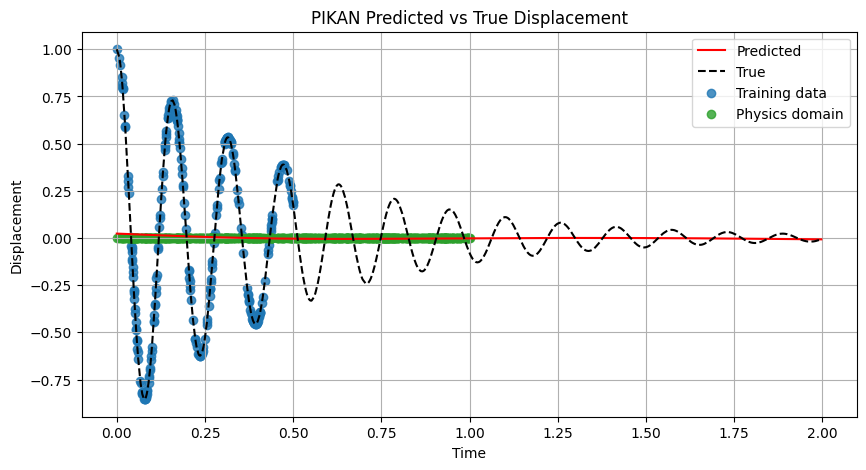

In [19]:
#plot predicted vs true displacement
model.eval()

ploss, dloss, icloss, x_true, x, t, train_mask = oscillator_loss(model, mu, k, d, w0, n=1200, t0=0.0, tL=2.0, train_frac=0.25, return_data=True)
x = x.squeeze().detach().numpy()
x_true = x_true.squeeze().detach().numpy()
t = t.squeeze().detach().numpy()
p = t.argsort()
t, x, x_true = t[p], x[p], x_true[p]
data_domain_mask = t<=0.5
physics_domain_mask = t<=1.0

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t, x, color="red", label='Predicted')
ax.plot(t, x_true, color="black", linestyle='--', label='True')
plt.scatter(t[data_domain_mask], x_true[data_domain_mask], color="tab:blue", alpha=0.8, label="Training data")
plt.scatter(t[physics_domain_mask], 0*t[physics_domain_mask], color="tab:green", alpha=0.8, label="Physics domain")
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('PIKAN Predicted vs True Displacement')
plt.legend()
plt.grid(True)
plt.show()




# Causal function approximation $f(t0,x0) = x(t1)$

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import KASSM
from utils import generate_oscillator_data, split_sequences, plot_sequences

# Example Usage
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [16, 16]

num_sequences = 3
total_seq_length = 3**6
t_l = 0.5
train_split_point = total_seq_length//8
test_split_point = int(2*train_split_point)

model = KASSM(state_dim, input_dim, output_dim, kan_layers)

# Example data
batch_size = 1
sequences, times = generate_oscillator_data(0, t_l, total_seq_length, num_sequences, d=4, w0=40)
data = torch.concat([sequences, times], dim=-1)
train_batch, val_batch, test_batch = split_sequences(data, train_split_point, test_split_point)

# generate inputs and states
state = train_batch[:, :, 0].reshape(-1, state_dim)
input = train_batch[:, :, 1].reshape(-1, input_dim)


from torchinfo import summary
print(summary(model, input_data=[state, input]))

# Forward pass
next_state, observation = model(state, input)

# loss
criterion = nn.MSELoss()
loss = criterion(next_state, state) + criterion(observation, observation_target)

print("Next State:", next_state.shape)
print("Observation:", observation.shape)
print("Loss:", loss.item())

Layer (type:depth-idx)                   Output Shape              Param #
KASSM                                    [273, 1]                  --
├─KAN: 1-1                               [273, 1]                  --
│    └─ModuleList: 2-1                   --                        --
│    │    └─KANLinear: 3-1               [273, 16]                 320
│    │    └─KANLinear: 3-2               [273, 16]                 2,560
│    │    └─KANLinear: 3-3               [273, 1]                  160
├─KAN: 1-2                               [273, 1]                  --
│    └─ModuleList: 2-2                   --                        --
│    │    └─KANLinear: 3-4               [273, 16]                 320
│    │    └─KANLinear: 3-5               [273, 16]                 2,560
│    │    └─KANLinear: 3-6               [273, 1]                  160
Total params: 6,080
Trainable params: 6,080
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB):

NameError: name 'observation_target' is not defined

Epoch [100/1000], Loss: 0.3725
Epoch [200/1000], Loss: 0.0003
Epoch [300/1000], Loss: 0.0001
Epoch [400/1000], Loss: 0.0001
Epoch [500/1000], Loss: 0.0001
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001


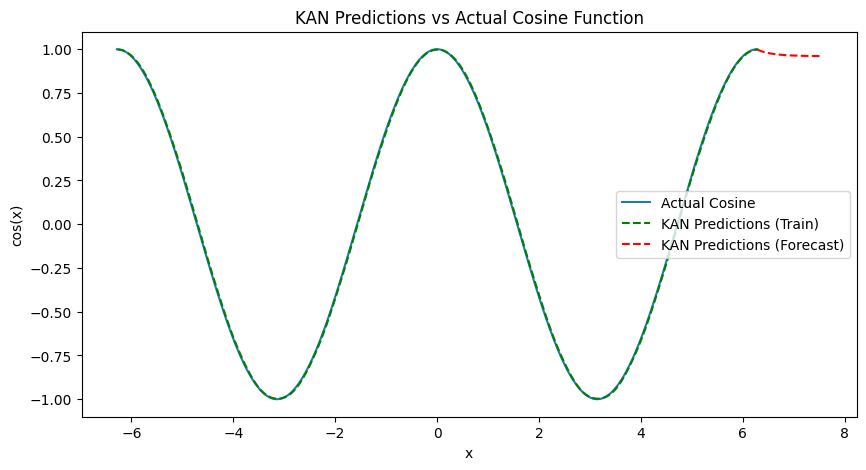

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate the data
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
y = np.cos(x)
x_train = y[:-1].reshape(-1, 1)
y_train = y[1:].reshape(-1, 1)

# Convert data to PyTorch tensors
x_tensor = torch.from_numpy(x_train).float()
y_tensor = torch.from_numpy(y_train).float()

# Initialize the model, loss function, and optimizer
model = KAN(
    layers_hidden=[1, 50, 50, 1],  # Define the layer sizes
    grid_size=5,
    spline_order=3,
    scale_noise=0.1,
    scale_base=1.0,
    scale_spline=1.0,
    base_activation=Cosine,
    grid_eps=0.02,
    grid_range=[-1, 1]
        )
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Make predictions
model.eval()
with torch.no_grad():
    future_x = x_tensor[-1].reshape(1, 1)
    future_predictions = []
    for _ in range(100):
        future_pred = model(future_x)
        future_predictions.append(future_pred.item())
        future_x = future_pred.reshape(1, 1)

# Prepare data for plotting
train_predictions = model(x_tensor).detach().numpy()
future_x_plot = np.linspace(x[-1], x[-1] + 100 * (x[1] - x[0]), 100)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Actual Cosine')
plt.plot(x[1:], train_predictions, 'g--', label='KAN Predictions (Train)')
plt.plot(future_x_plot, future_predictions, 'r--', label='KAN Predictions (Forecast)')
plt.legend()
plt.xlabel('x')
plt.ylabel('cos(x)')
plt.title('KAN Predictions vs Actual Cosine Function')
plt.show()
